## Quiz 1: Modelos de Regresión

### 1. Importación, limpieza y visualización de la matriz de datos

In [8]:
import csv
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

with open('data.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    csv_data = [row for row in reader]
numeric_data = []
for row in csv_data[1:]:
    clean_row = [cell.replace('\u200b', '').strip() for cell in row]
    try:
        numeric_row = [float(cell) for cell in clean_row]
        numeric_data.append(numeric_row)
    except ValueError:
        continue # Ignora las filas que no se pueden convertir

data = sp.Matrix(numeric_data)
data

Matrix([
[ 0.0, 0.04],
[ 1.0, 0.06],
[ 2.0, 0.08],
[ 3.0, 0.13],
[ 4.0, 0.22],
[ 5.0,  0.5],
[ 5.5, 0.89],
[ 5.8, 1.39],
[ 6.0,  2.0],
[ 8.0,  2.0],
[ 8.2, 1.39],
[ 8.5, 0.89],
[ 9.0,  0.5],
[10.0, 0.22],
[11.0, 0.13],
[13.0, 0.06],
[16.0, 0.02],
[17.0, 0.02],
[18.0, 0.02],
[19.0, 0.01],
[20.0, 0.01]])

### 2. Visualización Gráfica de los Datos

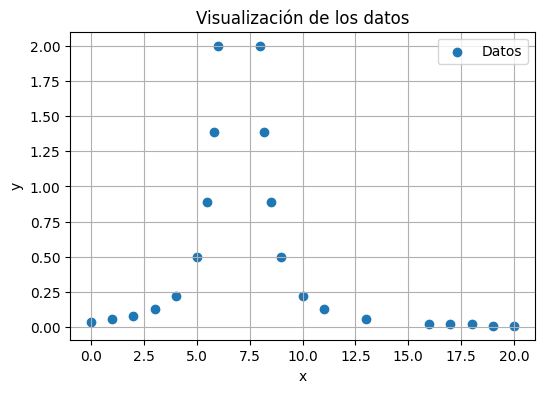

In [9]:
# Visualización de los datos
plt.figure(figsize=(6, 4))
plt.scatter(data[:, 0], data[:, 1], label='Datos')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Visualización de los datos')
plt.legend()
plt.grid(True)
plt.show()

# Convertir la matriz de datos a lista de tuplas
def prepare_data(raw_data):
    if isinstance(raw_data, sp.Matrix):
        return [(float(raw_data[i, 0]), float(raw_data[i, 1])) for i in range(raw_data.rows)]
    elif isinstance(raw_data, (list, tuple)):
        return [(float(xi), float(yi)) for xi, yi in raw_data]
    else:
        raise TypeError("Formato de datos no reconocido: use lista de tuplas o Sympy Matrix")

### 3. Escoger la función para la tendencia de los datos

#### a. Polinomial de Grado n

In [19]:
# Definir el modelo polinomial de grado n
n = 3
a = sp.symbols(f'a0:{n+1}')    # (a0, a1, ..., an)
x = sp.symbols('x')
model_poly = sum(a[i] * x**i for i in range(n+1))

data = prepare_data(data)

# Construir matriz A y vector y
def build_poly_system(data_list, degree):
    A = sp.Matrix([[xi**j for j in range(degree+1)] for xi, yi in data_list]) # A tendrá columnas [1, x, x^2, ..., x^n]
    y = sp.Matrix([yi for xi, yi in data_list])
    return A, y

A, y_vec = build_poly_system(data, n)

# Resolver sistema normal: (A^T A) * a_vec = A^T * y
AtA = A.T * A
Aty = A.T * y_vec

# Asegurarse de que AtA es invertible
if AtA.det() == 0:
    raise ValueError("La matriz A^T*A es singular para grado = {}.".format(n))

a_vec = AtA.inv() * Aty # vector [a0, a1, ..., an]

# Mostrar resultados
for i, coeff in enumerate(a_vec):
    print(f"a{i} = {sp.simplify(coeff)}")

adjusted_model = sp.simplify(model_poly.subs({a[i]: a_vec[i] for i in range(n+1)}))
print("\nModelo ajustado:")
y = sp.symbols('y')
display(sp.Eq(y, adjusted_model))

a0 = 1.28365443252375
a1 = 0.995445538592548
a2 = -0.173584379455974
a3 = 0.0403629782819497

Modelo ajustado:


Eq(y, 0.0403629782819497*x**3 - 0.173584379455974*x**2 + 0.995445538592548*x + 1.28365443252375)

#### b. Exponencial

Clasica

In [ ]:
# Modelo exponencial clásico: y = A * exp(B * x)
B0, B1, x = sp.symbols('B0 B1 x')
y = sp.symbols('y')

data = prepare_data(data)
data = [(xi, yi) for xi, yi in data if yi > 0]  # Evitar log(0)

# ln(y) = B1 * x + B0
data_log = [(xi, np.log(yi)) for xi, yi in data]
A = sp.Matrix([[xi, 1] for xi, _ in data_log])
b = sp.Matrix([yi for _, yi in data_log])

# Resolver sistema normal
AtA = A.T * A
Aty = A.T * b
B_vec = AtA.inv() * Aty

B1_val = float(B_vec[0])
B0_val = float(B_vec[1])
A_val = np.exp(B0_val)

adjusted_model = A_val * sp.exp(B1_val * x)
print("\nModelo exponencial clásico ajustado:")
display(sp.Eq(y, adjusted_model))


Modelo exponencial clásico ajustado:


Eq(y, 1.47192832367699*exp(0.316542782131792*x))

Inversa Asintotica

In [ ]:
# Modelo exponencial inverso: y = A * (1 - exp(-B * x))
B1, x = sp.symbols('B1 x')
y = sp.symbols('y')

A_val = 8  # Valor asintótico

data = prepare_data(data)
filtered_data = [(xi, yi) for xi, yi in data if 0 < yi < A_val]

# ln(A - y) = ln A - Bx
data_log = [(xi, np.log(A_val - yi)) for xi, yi in filtered_data]
A_mat = sp.Matrix([[xi, 1] for xi, _ in data_log])
y_vec = sp.Matrix([yi for _, yi in data_log])

# Resolver sistema normal
AtA = A_mat.T * A_mat
Aty = A_mat.T * y_vec
B_vec = AtA.inv() * Aty

B1_val = -float(B_vec[0])
adjusted_model = A_val * (1 - sp.exp(-B1_val * x))
print("\nModelo exponencial inverso ajustado:")
display(sp.Eq(y, adjusted_model))


Modelo exponencial inverso ajustado:


Eq(y, 8 - 8*exp(-0.330113983152154*x))

#### c. Logarítmica

In [ ]:
# Definir símbolos y modelo
C0, C1, x = sp.symbols('C0 C1 x')
model_logarithmic = C0 + C1*sp.log(x)

# Preparar datos
data = prepare_data(data)

# Filtrar x > 0 para evitar log(0) o log(x < 0)
data = [(xi, yi) for xi, yi in data if xi > 0]

# Transformar x -> ln(x) y montar sistema lineal
A = sp.Matrix([[np.log(xi), 1] for xi, yi in data]) #    modelo: y = C0 + C1 * ln(x)  ==>  columna [ln(x), 1]
y_vec = sp.Matrix([yi for xi, yi in data])

# Resolver las ecuaciones normales: (A^T A)·[C1, C0]^T = A^T·y
AtA = A.T * A
Aty = A.T * y_vec

if AtA.det() == 0:
    raise ValueError("A^T*A es singular en el modelo logarítmico.")

C_vec = AtA.inv() * Aty  # [C1, C0]
C1_val = float(C_vec[0])
C0_val = float(C_vec[1])

# Modelo ajustado simbólico
adjusted_model = model_logarithmic.subs({C0: C0_val, C1: C1_val})
print("\nModelo ajustado:")
y = sp.symbols('y')
display(sp.Eq(y, sp.simplify(adjusted_model)))


Modelo ajustado:


Eq(y, 1.48591820900231*log(x) + 4.40238895112307)

#### d. Potencial

In [ ]:
# Definir símbolos y modelo (transformado)
P0, P1, x = sp.symbols('P0 P1 x')
# Transformación: ln y = ln P0 + P1 * ln x
B0, B1 = sp.symbols('B0 B1')
model_log = B0 + B1*sp.log(x)

# Preparar datos
data = prepare_data(data)

# Transformar datos: (u = ln x, v = ln y)
data_log = [(np.log(xi), np.log(yi)) for xi, yi in data]
A = sp.Matrix([[ui, 1] for ui, vi in data_log])
y_vec = sp.Matrix([vi for ui, vi in data_log])

# Resolver sistema normal: (A^T A)·[B1, B0]^T = A^T·v
AtA = A.T * A
Aty = A.T * y_vec

if AtA.det() == 0:
    raise ValueError("A^T*A es singular en el modelo potencial.")

B_vec = AtA.inv() * Aty
B1_val = float(B_vec[0])   # P1
B0_val = float(B_vec[1])   # ln P0
P1_val = B1_val
P0_val = np.exp(B0_val)

print(f"P0 = {P0_val:.6f}, P1 = {P1_val:.6f}")

# Modelo ajustado simbólico
adjusted_model = P0_val * x**P1_val
print("\nModelo ajustado:")
y = sp.symbols('y')
display(sp.Eq(y, sp.simplify(adjusted_model)))

P0 = 1.000607, P1 = 1.050793

Modelo ajustado:


Eq(y, 1.00060724534419*x**1.05079269452626)

#### e. Trigonométrica

In [ ]:
# Definir símbolos
A, C, x = sp.symbols('A C x')

# Asignar B a partir del período estimado
x_max1 = 3
x_max2 = 10
T = abs(x_max2 - x_max1)
B_val = 2 * np.pi / T

# Modelo: y = A * sin(Bx + C), con B conocido
model = A * sp.sin(B_val * x + C)

# Preparar datos
data = prepare_data(data)

if len(data) < 2:
    raise ValueError("Se necesitan al menos 2 puntos para ajustar A y C.")

# Tomar 2 puntos y formar ecuaciones
(x1, y1), (x2, y2) = data[:2]
eq1 = sp.Eq(y1, A * sp.sin(B_val * x1 + C))
eq2 = sp.Eq(y2, A * sp.sin(B_val * x2 + C))

# Resolver sistema para A y C
sols = sp.solve([eq1, eq2], (A, C), dict=True)

if not sols:
    raise ValueError("No se pudo resolver el sistema trigonométrico.")

sol = sols[0]
A_val = sol[A]
C_val = sol[C]

# Sustituir en el modelo ajustado
adjusted_model = model.subs({A: A_val, C: C_val})
print("\nModelo ajustado:")
y = sp.symbols('y')
display(sp.Eq(y, adjusted_model))


Modelo ajustado:


Eq(y, -4.59674612024715*sin(0.897597901025655*x - 1.36526824089392))

#### f. Resorte Amortiguado

In [ ]:
# Definir símbolos
B0, B1, x = sp.symbols('B0 B1 x')  # ln(A) y C
A_sym, C_sym = sp.symbols('A C')   # para reemplazo final

# Estimar frecuencia angular w a partir de dos máximos o mínimos conocidos
x_max1 = 3
x_max2 = 10
T = abs(x_max2 - x_max1)
w = 2 * np.pi / T  # omega - frecuencia angular

# Preparar los datos
data = prepare_data(data)

# Transformación logarítmica del modelo: ln(y / cos(wx)) = B0 + B1 * x
data_transformed = []
for xi, yi in data:
    cos_val = np.cos(w * xi)
    if cos_val == 0 or yi / cos_val <= 0:
        continue # Evitar log de 0 o número negativo
    new_y = np.log(yi / cos_val)
    data_transformed.append((xi, new_y))

if len(data_transformed) < 2:
    raise ValueError("No hay suficientes datos válidos después de la transformación.")

# Matriz A y vector y para sistema lineal
A_mat = sp.Matrix([[xi, 1] for xi, _ in data_transformed])
y_vec = sp.Matrix([yi for _, yi in data_transformed])

# Resolver sistema normal: (A^T A) z = A^T y
AtA = A_mat.T * A_mat
Aty = A_mat.T * y_vec
sol_vec = AtA.inv() * Aty

B1_val = float(sol_vec[0])  # C
B0_val = float(sol_vec[1])  # ln(A)
A_val = np.exp(B0_val)
C_val = B1_val

# Modelo ajustado: y = A * exp(Cx) * cos(w x)
adjusted_model = A_val * sp.exp(C_val * x) * sp.cos(w * x)

# Mostrar el modelo
y = sp.symbols('y')
display(sp.Eq(y, adjusted_model))

Eq(y, 4.51885347629603*exp(-0.301113947783649*x)*cos(0.897597901025655*x))

#### g. Gausiana

In [21]:
# Definir símbolos
B0, B1, x = sp.symbols('B0 B1 x')  # ln(A), B
A_sym, B_sym = sp.symbols('A B')   # Coeficientes finales
C_val = 5

# Preparar los datos
data = prepare_data(data)

# Transformar los datos: z = (x - C)^2, y = ln(y)
transformed_data = []
for xi, yi in data:
    z = (xi - C_val)**2
    if yi <= 0:
        continue  # Evitar log de 0 o negativo
    transformed_data.append((z, np.log(yi)))

if len(transformed_data) < 2:
    raise ValueError("Insufficient valid points after transformation.")

# Construir matriz A y vector y para el sistema lineal
A_mat = sp.Matrix([[zi, 1] for zi, _ in transformed_data])
y_vec = sp.Matrix([yi for _, yi in transformed_data])

# Resolver el sistema normal: (A^T A) * [B1, B0]^T = A^T * y
AtA = A_mat.T * A_mat
Aty = A_mat.T * y_vec
solution = AtA.inv() * Aty

# Extraer los valores de B1 y B0
B1_val = float(solution[0])
B0_val = float(solution[1])
A_val = np.exp(B0_val)
B_val = -B1_val

# Modelo ajustado
adjusted_model = A_val * sp.exp(-B_val * (x - C_val)**2)
print("\nModelo ajustado:")
y = sp.symbols('y')
display(sp.Eq(y, adjusted_model))
A_mat


Modelo ajustado:


Eq(y, 0.160386678896932*exp(-0.0104051395541618*(x - 5)**2))

Matrix([
[              625.0, 1],
[           622.5025, 1],
[             620.01, 1],
[           617.5225, 1],
[             615.04, 1],
[           612.5625, 1],
[             610.09, 1],
[           607.6225, 1],
[             605.16, 1],
[           602.7025, 1],
[             600.25, 1],
[           597.8025, 1],
[             595.36, 1],
[           592.9225, 1],
[             590.49, 1],
[           588.0625, 1],
[             585.64, 1],
[           583.2225, 1],
[             580.81, 1],
[           578.4025, 1],
[              576.0, 1],
[           573.6025, 1],
[             571.21, 1],
[           568.8225, 1],
[             566.44, 1],
[           564.0625, 1],
[             561.69, 1],
[           559.3225, 1],
[             556.96, 1],
[           554.6025, 1],
[             552.25, 1],
[           549.9025, 1],
[             547.56, 1],
[           545.2225, 1],
[             542.89, 1],
[           540.5625, 1],
[             538.24, 1],
[           535.9225, 1],
[  

#### h. Exponencial con Coseno

In [20]:
# Definir símbolos
c, x = sp.symbols('c x')
y = sp.symbols('y')

# Parámetro ω estimado visualmente (puedes cambiar estos valores)
x_max1 = 0
x_max2 = 2 * np.pi
T = abs(x_max2 - x_max1)
w = 2 * np.pi / T

# Preparar los datos
data = prepare_data(data)

# Filtrar puntos donde cos(w*x) ≠ 0 y y/cos(wx) > 0
filtered_data = []
for xi, yi in data:
    cos_val = np.cos(w * xi)
    if abs(cos_val) < 1e-6:
        continue  # evitar división por cero
    ratio = yi / cos_val
    if ratio > 0:
        filtered_data.append((xi, np.log(ratio)))

# Si no hay suficientes puntos, abortar
if len(filtered_data) < 2:
    raise ValueError("No hay suficientes puntos válidos para linealizar.")

# Montar sistema A * c = ln(y / cos(wx))
A = sp.Matrix([[xi**2] for xi, _ in filtered_data])
y_vec = sp.Matrix([val for _, val in filtered_data])

# Resolver sistema normal
AtA = A.T * A
Aty = A.T * y_vec
c_val = float((AtA.inv() * Aty)[0])

# Modelo ajustado
adjusted_model = sp.exp(c_val * x**2) * sp.cos(w * x)

# Mostrar modelo
print("\nModelo ajustado:")
display(sp.Eq(y, adjusted_model))


Modelo ajustado:


Eq(y, exp(-0.02*x**2)*cos(1.0*x))

#### i. Asintótica

In [10]:
# Definir símbolos
A_sym, B_sym, x = sp.symbols('A B x')
y = sp.symbols('y')

data = prepare_data(data)

# Asumimos centro conocido
center = 7

# Filtrar donde y > 0 y x ≠ center
filtered_data = [(xi, yi) for xi, yi in data if yi > 0 and xi != center]
if len(filtered_data) < 2:
    raise ValueError("No hay suficientes datos válidos para ajustar el modelo.")

# Linealización: ln(y) = ln(A) - B * ln(|x - c|)
A_matrix = sp.Matrix([[1, -np.log(abs(xi - center))] for xi, yi in filtered_data])
y_vec = sp.Matrix([np.log(yi) for _, yi in filtered_data])

# Resolver el sistema normal
AtA = A_matrix.T * A_matrix
Aty = A_matrix.T * y_vec
if AtA.det() == 0:
    raise ValueError("La matriz A^T*A es singular.")
solution = AtA.inv() * Aty

# Extraer parámetros
lnA_val = float(solution[0])
B_val = float(solution[1])
A_val = np.exp(lnA_val)

# Modelo ajustado
adjusted_model = A_val / (abs(x - center) ** B_val)

print("\nModelo ajustado:")
display(sp.Eq(y, adjusted_model))


Modelo ajustado:


Eq(y, 2.05686830915934/Abs(x - 7)**2.03417414120434)

### 4. Visualización y Análisis de Resultados

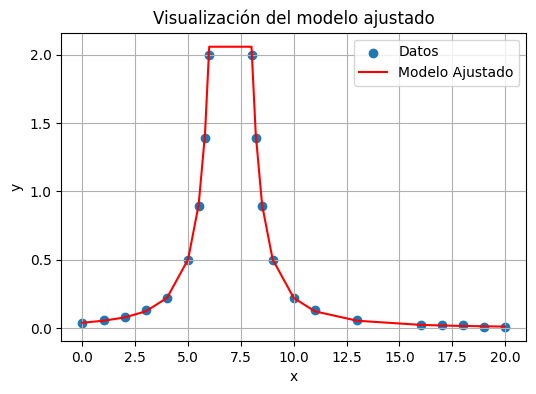

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 5.5, 5.8, 6.0, 8.0, 8.2, 8.5, 9.0, 10.0, 11.0, 13.0, 16.0, 17.0, 18.0, 19.0, 20.0]


In [ ]:
# Visualizar el modelo ajustado
plt.figure(figsize=(6, 4))
plt.scatter([xi for xi, yi in data], [yi for xi, yi in data], label='Datos')
x_vals = [xi for xi, yi in data]
y_vals = [adjusted_model.subs(x, xi) for xi in x_vals]
plt.plot(x_vals, y_vals, color='red', label='Modelo Ajustado')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Visualización del modelo ajustado')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Evaluar el modelo ajustado
# Calcular R cuadrado (Coeficiente de determinación)
y_actual = [yi for xi, yi in data]
y_predicted = [adjusted_model.subs(x, xi) for xi, yi in data]

# Suma total de cuadrados (SST)
sst = sum((yi - sp.Rational(sum(y_actual) / len(y_actual)))**2 for yi in y_actual)

# Suma de cuadrados residuales (SSR)
ssr = sum((yi - y_pred)**2 for yi, y_pred in zip(y_actual, y_predicted))

# R cuadrado
r_squared = 1 - (ssr / sst)

# Calcular el Error Cuadrático Medio (ECM)
ecm = ((sum((yi - y_pred)**2 for yi, y_pred in zip(y_actual, y_predicted)) / len(y_actual))** 0.5)

print(f"R cuadrado: {r_squared}")
print(f"ECM: {ecm}")

R cuadrado: 0.999004748090875
ECM: 0.0203816874152554
